In [782]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [783]:
log_files = os.listdir( '../logs')

In [784]:
jsons = [i for i in log_files if i.endswith('.json')]

In [785]:
# open json files using pandas, add column with file name and trial number (old index) and concat
df = pd.concat([pd.read_json('../logs/' + i, orient='index').assign(dyad=trial + 1) for trial, i in enumerate(jsons)])

In [786]:
# add new column with row number from 1 to 30 for each trial
df['trial'] = df.groupby('dyad').cumcount() + 1
df['word_length'] = df['word'].apply(len)
df['word_length_cat'] = np.where(df['word_length'] < 5, 'short', 'long')

In [787]:
true_context = {'T': ['r'], 'C': ['l'], 'S': ['r', 'l']}
# verify if the stimulus_out has the same context as "context" in df
df['correct_context'] = df.apply(lambda x: true_context[x['stimulus_out']] == true_context[x['stimulus']], axis=1)
# average correct_context for each trial for last 20 trials
df.groupby('dyad').apply(lambda x: x.iloc[-20:]['correct_context'].mean())
# set this value as "context_score" for each dyad
df['context_score'] = df.groupby('dyad').apply(lambda x: x.iloc[-20:]['correct_context'].mean()).values[df['dyad'] - 1]

In [788]:
# only consider dyads with context_score > 0.5
# df = df[df['context_score'] >= 0.5]

In [789]:
# label S as "non-informative" and C and T as "informative"
df['informative'] = df['stimulus'].apply(lambda x: 'no' if x == 'S' else 'yes')

In [790]:
# count context stimulus combinations
df.groupby(['context', 'stimulus']).size()

context  stimulus
l        C           60
         S           30
r        S           30
         T           60
dtype: int64

In [791]:
df.head()

,stimulus,context,word,stimulus_out,correct,score,dyad,trial,word_length,word_length_cat,correct_context,context_score,informative
1,S,r,rabu,S,True,1,1,1,4,short,True,0.45,no
2,C,l,rabu,S,False,1,1,2,4,short,False,0.45,yes
3,T,r,rabu,S,False,1,1,3,4,short,False,0.45,yes
4,S,r,tabudiga,T,False,1,1,4,8,long,False,0.45,no
5,C,l,tabudiga,C,True,2,1,5,8,long,True,0.45,yes


In [792]:
# average accuracy per dyad 
df.query('trial > 9').groupby('dyad')['correct'].mean()

dyad
1    0.476190
2    0.619048
3    0.523810
4    1.000000
5    0.380952
6    0.523810
Name: correct, dtype: float64

In [793]:
# even trial should be Player 1 and odd trial should be Player 2
df['player'] = df['trial'].apply(lambda x: 'Player 1' if x % 2 == 0 else 'Player 2')

In [794]:
df.to_csv('../logs/logs_full.csv')

In [795]:
# count the number of times each word was used per dyad
df.groupby(['dyad', 'word']).size()

dyad  word    
1     rabu        13
      tabudiga    17
2     rabu        17
      tabudiga    13
3     rabu        24
      tabudiga     6
4     calymaic    10
      lyfy        20
5     rabu        14
      tabudiga    16
6     lyun        15
      uninrere    15
dtype: int64

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_37156/3451922728.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='trial', y='correct_5', data=df, ax=ax2, ci=95)


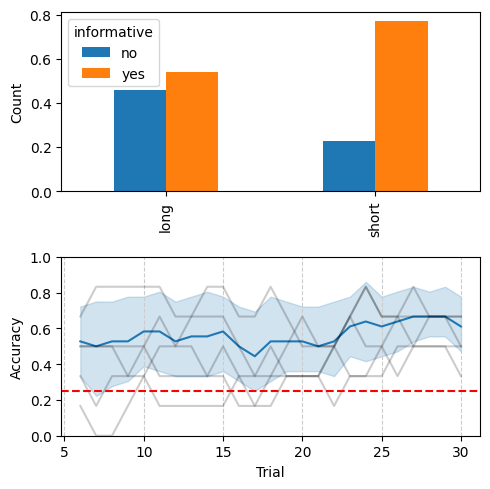

In [796]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
df.query('trial > 10').groupby(['word_length_cat', 'informative']).count()['trial'].unstack().apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', ax = ax1)
ax1.set_ylabel('Count')
ax1.set_xlabel('')

# rolling mean of correct_5 for each dyad
df['correct_5'] = df.groupby('dyad')['correct'].rolling(6).mean().reset_index(0, drop=True)
df.reset_index(inplace=True, drop=True)
sns.lineplot(x='trial', y='correct_5', data=df, ax=ax2, ci=95)
# plot individual trials as well
for i in df['dyad'].unique():
    plt.plot(df[df['dyad'] == i]['trial'], df[df['dyad'] == i]['correct_5'], color='black', alpha=0.2)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Trial')
ax2.set_ylim(0, 1)
ax2.grid(axis='x', which='major', color='#CCCCCC', linestyle='--')
ax2.axhline(0.25, color='red', linestyle='--')
plt.tight_layout()
plt.show()


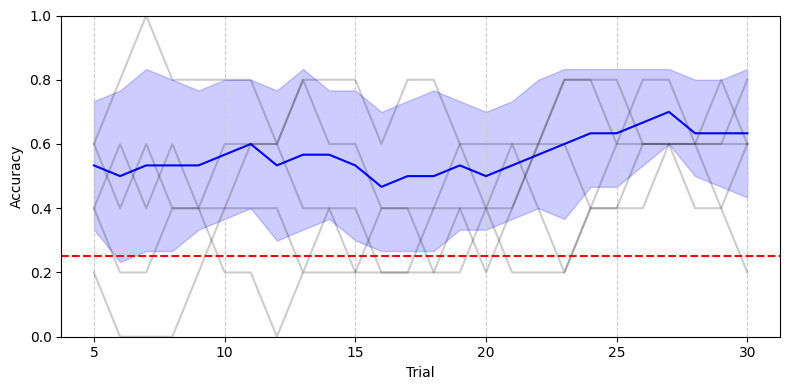

In [797]:
plt.figure(figsize=(8, 4))
df['correct_5'] = df.groupby('dyad')['correct'].rolling(5).mean().reset_index(0, drop=True)
df.reset_index(inplace=True, drop=True)
sns.lineplot(x='trial', y='correct_5', data=df, errorbar='ci', color='blue')
# plot individual trials as well
for i in df['dyad'].unique():
    plt.plot(df[df['dyad'] == i]['trial'], df[df['dyad'] == i]['correct_5'], color='black', alpha=0.2)
plt.ylabel('Accuracy')
plt.xlabel('Trial')
plt.ylim(0, 1)
plt.grid(axis='x', which='major', color='#CCCCCC', linestyle='--')
plt.axhline(0.25, color='red', linestyle='--')
plt.tight_layout()
plt.show()

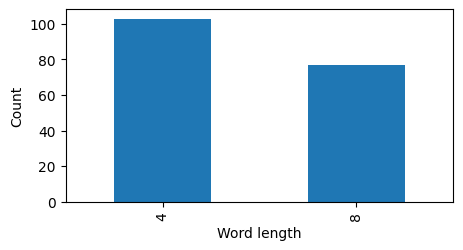

In [798]:
# count word frequency and plot it against length of word
plt.figure(figsize=(5, 2.5))
df.groupby('word_length').count()['word'].plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Word length')
plt.show()

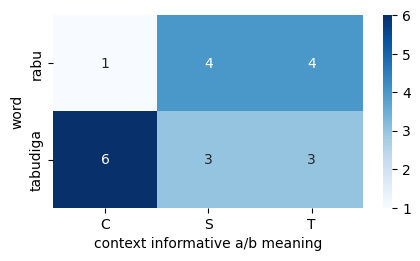

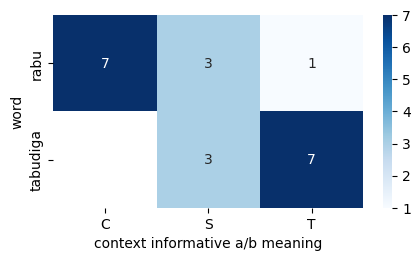

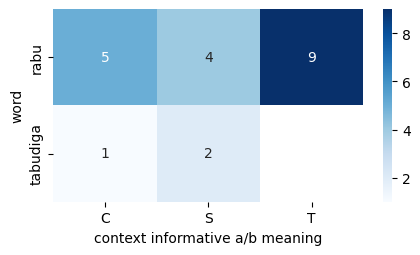

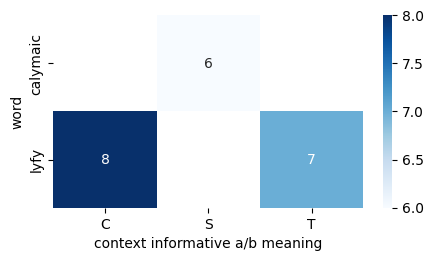

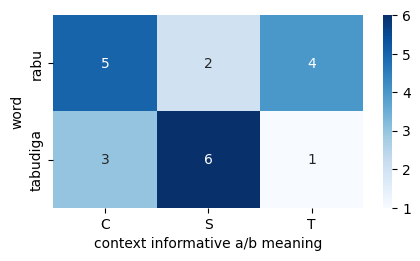

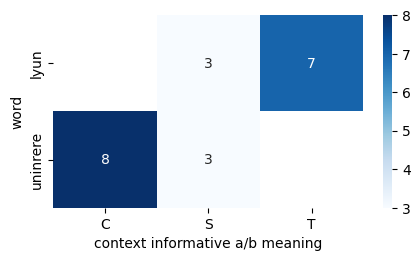

In [799]:
# plot word and stimulus count heatmap
for i in df['dyad'].unique():
    plt.figure(figsize=(5, 2.5))
    sns.heatmap(df.query(f'dyad == {i} & trial > 9').groupby(['word', 'stimulus']).count()['trial'].unstack(), cmap='Blues', annot=True, fmt='g')
    plt.xlabel('context informative a/b meaning')
    plt.ylabel('word')
    plt.show()


In [800]:
# # plot a heatmap of word and stimulus correct count
# for i in df['dyad'].unique():
#     plt.figure(figsize=(5, 2.5))
#     # ingore warnings from sns
#     sns.heatmap(df.query(f'dyad == {i} & trial > 9').groupby(['word', 'stimulus']).mean()['correct'].unstack(), 
#                 cmap='Blues', 
#                 annot=True, 
#                 fmt='.2f')
#     plt.xlabel('context informative a/b meaning')
#     plt.ylabel('word')
#     plt.show()

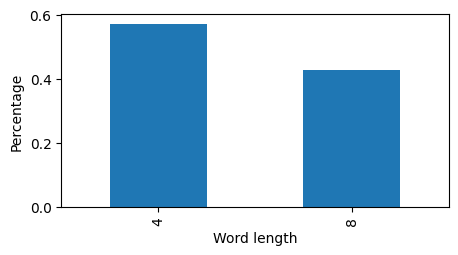

In [801]:
# count word frequency as percentage per dyad and plot it against length of word
plt.figure(figsize=(5, 2.5))
df.groupby(['dyad', 'word_length']).count()['word'].unstack().apply(lambda x: x / x.sum(), axis=1).mean().plot(kind='bar')
plt.ylabel('Percentage')
plt.xlabel('Word length')
plt.show()

In [802]:
# count appearance of each stimulus in each dyad
df.groupby(['dyad', 'stimulus']).count()['word'] 
# add this information to df
df['stimulus_count'] = df.groupby(['dyad', 'stimulus']).transform('count')['word']

In [803]:
# # count accuracy for each stimulus in each dyad, as well as stimulus count
df[['dyad', 'stimulus', 'correct']].groupby(['dyad', 'stimulus']).mean()['correct']

dyad  stimulus
1     C           0.5
      S           0.4
      T           0.4
2     C           0.9
      S           0.1
      T           0.9
3     C           0.5
      S           0.4
      T           0.6
4     C           1.0
      S           1.0
      T           1.0
5     C           0.4
      S           0.3
      T           0.5
6     C           0.5
      S           0.2
      T           0.6
Name: correct, dtype: float64

In [804]:
# # count accuracy for each stimulus in each dyad, as well as stimulus count
df[['dyad', 'stimulus', 'correct', 'word']].groupby(['dyad', 'word', 'stimulus']).mean()['correct'] 

dyad  word      stimulus
1     rabu      C           0.000000
                S           0.800000
                T           0.333333
      tabudiga  C           0.625000
                S           0.000000
                T           0.500000
2     rabu      C           0.900000
                S           0.000000
                T           0.000000
      tabudiga  S           0.250000
                T           1.000000
3     rabu      C           0.555556
                S           0.500000
                T           0.666667
      tabudiga  C           0.000000
                S           0.250000
                T           0.000000
4     calymaic  S           1.000000
      lyfy      C           1.000000
                T           1.000000
5     rabu      C           0.333333
                S           0.666667
                T           0.200000
      tabudiga  C           0.500000
                S           0.142857
                T           0.800000
6     lyun   

In [805]:
# if word is "rabu" then the column "press time" is 1, otherwise 4
df['press_time'] = df['word_length'].apply(lambda x: 1 if x == 4 else 4)

In [806]:
df[['dyad', 'correct', 'trial', 'informative', 'press_time']].query('trial > 9').groupby(['dyad', 'informative']).mean()['press_time']

dyad  informative
1     no             2.285714
      yes            2.928571
2     no             2.500000
      yes            2.400000
3     no             2.000000
      yes            1.200000
4     no             4.000000
      yes            1.000000
5     no             3.250000
      yes            1.923077
6     no             2.500000
      yes            2.600000
Name: press_time, dtype: float64

<Axes: xlabel='word_length'>

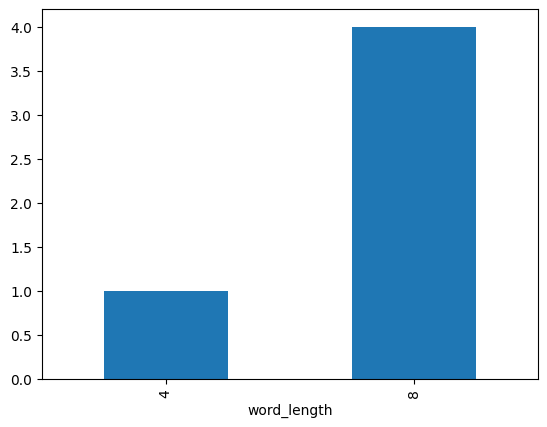

In [807]:
df[['press_time', 'word_length']].groupby('word_length').mean()['press_time'].plot(kind='bar')

<Axes: xlabel='word_length'>

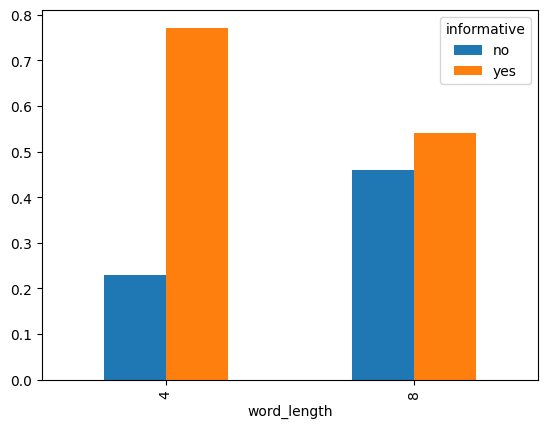

In [808]:
# same figure but with percentage per word
df.query('trial > 10').groupby(['word_length', 'informative']).count()['trial'].unstack().apply(lambda x: x / x.sum(), axis=1).plot(kind='bar')

In [809]:
# count how many times rabu was used with yes informative in each dyad
inf_short = (df.query('word_length == 4 & informative == "yes"').groupby('dyad').count()['trial'] / df.query('word_length == 4').groupby('dyad').count()['trial']).to_numpy()

In [810]:
ninf_long = (df.query('word_length == 8 & informative == "no"').groupby('dyad').count()['trial'] / df.query('word_length == 8').groupby('dyad').count()['trial']).to_numpy()

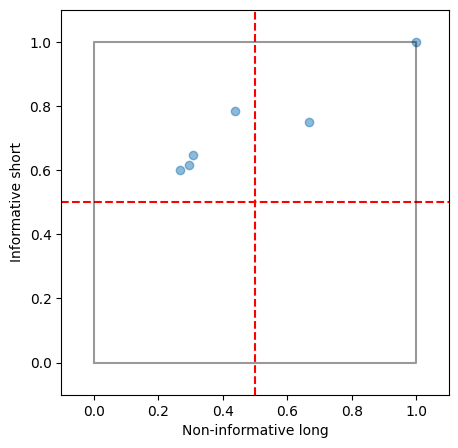

In [811]:
plt.figure(figsize=(5, 5))
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.scatter(ninf_long, inf_short, alpha=0.5)
# add a vertical line at 0.5
plt.axvline(0.5, color='red', linestyle='--')
# add a horizontal line at 0.5
plt.axhline(0.5, color='red', linestyle='--')
# add a square from 0, 0 to 1, 1
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', alpha = 0.4)
plt.xlabel('Non-informative long')
plt.ylabel('Informative short')
plt.show()